In [1]:
import os
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pylab as plt
import cPickle as pickle
import itertools
from matplotlib.path import Path
import matplotlib.patches as patches

In [2]:
from fuel.datasets.hdf5 import H5PYDataset
import fuel
datasource = 'sketch'
datasource_dir = os.path.join(fuel.config.data_path, datasource)
datasource_fname = os.path.join(datasource_dir , datasource+'.hdf5')

Using gpu device 0: GeForce GTX 980


In [3]:
!mkdir -p {datasource_dir}

#Download

Download human sketches stored in SVG from the work of

    Eitz, Mathias and Hays, James and Alexa, Marc, "How Do Humans Sketch Objects?", ACM Transactions on Graphics (Proceedings SIGGRAPH), 2012, Volume 31, Number 4, pages 44:1--44:10

In [4]:
import scipy.io
import os

m = scipy.io.loadmat(os.path.join(datasource_dir,'sketches_matlab/sketches.mat'))

In [5]:
sketches = m['D']
sketches.shape

(20000, 3)

#Read SVG matlab

In [6]:
def imgpoints(img):
    points = []
    
    strikes = sketches[img,2][:,0]
    lastx = lasty = 0
    for i in range(5,len(strikes)-3):
        s = strikes[i][0]
        j = s.find('d="M')
        assert j >=0
        s = s[j+len('d="M'):]
        assert s.endswith('"/>')
        s = s[:-len('"/>')]
        s = s.replace('C',' ').replace('L',' ').replace(',',' ')
        s = s.split()
        s = map(float,s)
        assert len(s) % 2 == 0
        count = 0
        for j in range(0,len(s),2):
            x, y = s[j],s[j+1]
            if np.isnan(x) or np.isnan(y):
                assert np.isnan(x) and np.isnan(y)
                continue
            points.append((x-lastx,y-lasty,count == 0))
            count += 1
            lastx,lasty = x,y
        assert count > 1
    return np.array(points[1:])

In [7]:
sketches_arrays = []
for img in xrange(len(sketches)):
    sketch = imgpoints(img)[1:]
    sketches_arrays.append(sketch)

##filter long sketches

In [8]:
lens = map(len, sketches_arrays)

In [9]:
min(lens), max(lens)

(17, 3959)

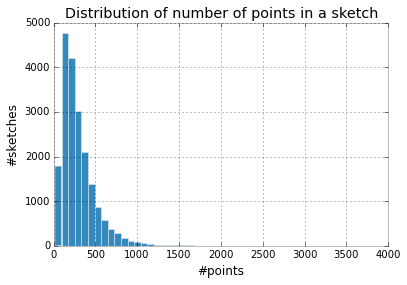

In [10]:
plt.hist(lens,bins=50)
plt.xlabel('#points')
plt.ylabel('#sketches')
plt.title('Distribution of number of points in a sketch');

In [11]:
sketches_arrays_idx = filter(lambda i: len(sketches_arrays[i])<1200, range(len(sketches_arrays)))
N = len(sketches_arrays_idx)
N

19885

##normalize

In [12]:
xys = np.vstack([sketches_arrays[i][:,:2] for i in sketches_arrays_idx])
xys.shape

(5693675, 2)

In [13]:
s = xys.std()
s

22.718561804436927

In [14]:
X = np.empty((N,1200,3))
for i,j in enumerate(sketches_arrays_idx):
    p = sketches_arrays[j]
    n = len(p)
    X[i,:n,:2] = p[:,:2]/s
    X[i,n:,:2] = 0
    X[i,:n,2] =  p[:,2]
    X[i,n:,2] = 1

In [15]:
X.shape

(19885, 1200, 3)

##shuffle

In [16]:
import random
X = X[random.sample(xrange(N),N)]

##Save in HDF5

In [17]:
!rm {datasource_fname}

In [18]:
import h5py
fp = h5py.File(datasource_fname, mode='w')
image_features = fp.create_dataset('features', X.shape, dtype='float32')

In [19]:
image_features[...] = X

In [20]:
N_train = int(9*len(X)/10)
N_train

17896

In [21]:
split_dict = {
    'train': {'features': (0, N_train)},
    'test': {'features': (N_train, N)}
}
fp.attrs['split'] = H5PYDataset.create_split_array(split_dict)

In [22]:
fp.flush()
fp.close()

#Test

In [23]:
train_set = H5PYDataset(datasource_fname, which_set='train')

In [24]:
train_set.num_examples

17896

In [25]:
handle = train_set.open()
data = train_set.get_data(handle, slice(0, 16))
data[0].shape, data[0].dtype, data[0].max()

((16, 1200, 3), dtype('float32'), 17.430681)

In [26]:
train_set.close(handle)

In [27]:
from sketch import drawpoints

/Users/udi/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1318: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


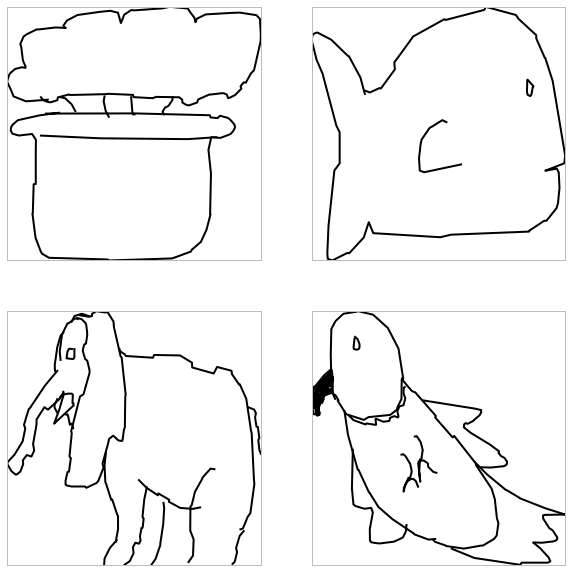

In [28]:
plt.figure(figsize=(10,10))
count = 1
M = 4
for points in data[0]:
    plt.subplot(2,2,count)
    count += 1
    drawpoints(points)
    if count > M: break